In [24]:
import os
import sys

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch3d
from pytorch3d.io import load_obj, save_obj, load_objs_as_meshes
from pytorch3d.structures import Meshes, Pointclouds
from pytorch3d.ops import sample_points_from_meshes, knn_points, estimate_pointcloud_normals, knn_gather, cubify, SubdivideMeshes

import trimesh

from torch_scatter import scatter

from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt

import pyvista as pv
pv.start_xvfb()
pv.set_jupyter_backend('html')

import torch
import pytorch3d 
from pytorch3d.ops import knn_points,knn_gather
from pytorch3d.transforms import axis_angle_to_matrix, matrix_to_axis_angle


from tqdm import tqdm

from pytorch3d.utils import ico_sphere

# # from pytorch3d.structures import Meshes

# from .utils import one_hot_sparse


In [25]:
from ops.mesh_geometry import *
from ops.pcl_geometry import *

In [26]:
device = torch.device("cuda:1")


trg_mesh = load_objs_as_meshes(["./dataset/org_data/Hilb64Thick.obj"], device=device)

# trg_mesh = ico_sphere(5, device)
trg_mesh = SubdivideMeshes().forward(trg_mesh)[0]

trg_mesh = normalize_mesh(trg_mesh)

In [27]:
trimesh.Trimesh(trg_mesh.verts_packed().detach().cpu().numpy(), trg_mesh.faces_packed().detach().cpu().numpy()).euler_number

0

In [28]:
folder = '/home/yihao/data/Torch3d_Curvature/dataset/org_data'
model_list = os.listdir(folder)
model_list

['spherical_rind_shape_wide_strips.obj',
 'ChicagoLion.obj',
 'holes_human.obj',
 'TriakisTetrahedron.obj',
 'art_print3d.obj',
 'OrganicSphere.obj',
 'Hilb64Thick.obj',
 'quirrel.obj',
 'ico_4.obj',
 'Knot.obj',
 'Venus.obj',
 'DeltoidalIcositetrahedron.obj',
 'kitten.obj',
 'Hundepaar.obj',
 'TeaPot.obj',
 'Bunny.obj',
 'father_remesh.obj',
 'QueenAnneChair.obj',
 'art_print3d2.obj',
 'Mushroom.obj',
 'genus_6_surface.obj',
 'holes_human copy.obj']

In [29]:
# model_list = [
#  'ChicagoLion.obj',]

In [34]:
import warnings
warnings.filterwarnings("ignore")


device = torch.device("cuda:1")

for i in range(len(model_list)):

    trg_mesh = load_objs_as_meshes(["./dataset/org_data/"+model_list[i]], device=device)
    trg_trimesh = trimesh.Trimesh(vertices=trg_mesh.verts_packed().cpu().numpy()*np.array([[1,-1,1]]), faces=trg_mesh.faces_packed().cpu().numpy())

    print(model_list[i][:-4])

    # for j in range(2):
    #     trg_mesh = SubdivideMeshes().forward(trg_mesh)[0]

    trg_mesh = normalize_mesh(trg_mesh)


    num_samples = 10000
    

    k = 30


    pointscloud, normals_gt = sample_points_from_meshes(trg_mesh, num_samples, return_normals=True)

    pointscloud = torch.cat([trg_mesh.verts_padded(), pointscloud], dim=-2)
    pointscloud = pointscloud + torch.randn_like(pointscloud)*0.025
    normals_gt = torch.cat([trg_mesh.verts_normals_padded(), normals_gt], dim=-2)


    area_gt = dual_area_vertex(trg_mesh).view(-1)

    pcl_with_frames = Differentiable_Global_Geometry_PointCloud(pointscloud, k = k)

    frames = pcl_with_frames.frames_field.clone()
    frames[:,:,0,:] = normals_gt

    N_v = trg_mesh.num_verts_per_mesh()[0]

    curvature = pcl_with_frames.gaussian_curvature(frames).view(-1)

    area = pcl_with_frames.local_voronoi_area(frames).view(-1)

    euler_0 = (curvature  * area).sum()/2/np.pi

    euler_0 = euler_0.item()

    print('GT euler', trg_trimesh.euler_number, 'GT Genus',  np.round(1-trg_trimesh.euler_number/2))

    print('Estimated euler',  euler_0)
    print('Estimated Genus',  np.round(1-euler_0/2))


    curvature = pcl_with_frames.gaussian_curvature().view(-1)

    area = pcl_with_frames.local_voronoi_area().view(-1)

    euler_0 = (curvature  * area).sum()/2/np.pi

    euler_0 = euler_0.item()

    print('Estimated euler wo normals',  euler_0)
    print('Estimated Genus wo normals',  np.round(1-euler_0/2))

    print('=========================================')



    # pl = pv.Plotter(notebook=True)
    # curvatures_v =  np.tanh((curvature[:N_v] * area_gt*100).cpu().numpy())

    # curvatures_nv =  (curvature).cpu().numpy()[N_v:]


    # current_trimesh = trimesh.Trimesh(vertices=trg_mesh.verts_packed().cpu().numpy()*np.array([[1,-1,1]]), faces=trg_mesh.faces_packed().cpu().numpy())
    # pointscloud = (pointscloud+normals_gt*0.005).cpu().numpy()[0, N_v:,:]*np.array([[1,-1,1]])
    # print('euler_gt', current_trimesh.euler_number)
    
    # current_trimesh = pv.wrap(current_trimesh)
    # light = pv.Light(light_type='headlight', intensity=0.6)
    # pl.add_mesh(current_trimesh, scalars=curvatures_v, cmap='viridis', show_scalar_bar=False, clim=[-1,1], ambient=0.3, diffuse=0.6, specular=0.1,
    #              specular_power=30, smooth_shading=True, opacity=1)
    

    # pl.add_points(pointscloud, scalars=curvatures_nv, cmap='viridis', render_points_as_spheres=True, point_size=3, show_scalar_bar=False, 
    #               clim=[-1,1], opacity=1)
                  
    # pl.add_light(light) 
    # pl.enable_shadows()
    # # pl.add_title("Euler: %.4f"% euler, font_size=10)
    # pl.camera.elevation = -20
    # pl.camera.azimuth = 10
    # pl.show()
    # # pl.show(screenshot='/home/yihao/data/Torch3d_Curvature/exp/our_results/'+model_list[i].split('.')[0]+'.png')
    # pl.close()

    



spherical_rind_shape_wide_strips
GT euler -12 GT Genus 7.0
Estimated euler 2.6326165199279785
Estimated Genus -0.0
Estimated euler wo normals -3.0323092937469482
Estimated Genus wo normals 3.0
ChicagoLion
GT euler -4 GT Genus 3.0
Estimated euler -1.8742891550064087
Estimated Genus 2.0
Estimated euler wo normals -7.28520393371582
Estimated Genus wo normals 5.0
holes_human
GT euler -402 GT Genus 202.0
Estimated euler -73.37776184082031
Estimated Genus 38.0
Estimated euler wo normals -59.349735260009766
Estimated Genus wo normals 31.0
TriakisTetrahedron
GT euler -20 GT Genus 11.0
Estimated euler 2.272629499435425
Estimated Genus -0.0
Estimated euler wo normals -3.424680471420288
Estimated Genus wo normals 3.0
art_print3d
GT euler -102 GT Genus 52.0
Estimated euler -23.39022445678711
Estimated Genus 13.0
Estimated euler wo normals -53.00949478149414
Estimated Genus wo normals 28.0
OrganicSphere
GT euler 2 GT Genus 0.0
Estimated euler 1.4171825647354126
Estimated Genus 0.0
Estimated euler w

In [31]:
trg_mesh.num_verts_per_mesh()

tensor([86414], device='cuda:1')

In [44]:
pcl_with_frames.knn_info.knn.shape

torch.Size([1, 19076, 10, 6])

In [14]:
pl = pv.Plotter(notebook=True, window_size=(768,768), border=False)
wein = pcl_with_frames.weingarten_fields()
mean_curv = (wein[:,:,0,0] + wein[:,:,1,1])/2
total_curv = wein.pow(2).sum(dim=(2,3)).sqrt()

area = pcl_with_frames.local_voronoi_area().view(-1)
rescaled_curv = area

print('Estimated Genus',  torch.round(1-pcl_with_frames.differentiable_euler_number()[0]/2).item())

print('Estimated euler',  pcl_with_frames.differentiable_euler_number()[0])

print('Estimated Area',  area.sum().item(), 'GT Area', trg_mesh.faces_areas_packed().sum().item())

alpha_scalars = 0.8 #- torch.exp(-torch.abs(curvature*area*5)).detach().cpu().numpy()

trg_trimesh = trimesh.Trimesh(trg_mesh.verts_packed().detach().cpu().numpy(), trg_mesh.faces_packed().detach().cpu().numpy())


# pl.add_mesh(trg_trimesh, color='lightblue', opacity=0.2)
scalars = (torch.sigmoid((total_curv*area-0.002)*200).detach().cpu().numpy())

cmap = "bone_r"

# pl.add_mesh(trg_trimesh, scalars =scalars, cmap= cmap,
#             opacity=1, scalar_bar_args={'title': 'Total Curvature (per Area)', 'position_x':0.2, 'position_y':0.0, 'label_font_size':0},
#             style='surface')

# pl.add_mesh(trg_trimesh, scalars= np.abs(area_gt.detach().cpu().numpy() - area.detach().cpu().numpy()), cmap= "Reds",
#             opacity=1, scalar_bar_args={'title': 'Area Difference', 'position_x':0.2, 'position_y':0.0}, style='surface')
pl.camera.roll = -20
pl.camera.elevation = 50
pl.camera.azimuth = -60
pl.camera.zoom = 1.2

pl.add_points(pcl_with_frames.pointscloud.detach().cpu().numpy()[0], 
              scalars=scalars,
              point_size=4,cmap=cmap,
              show_scalar_bar = False,
                render_points_as_spheres=True,
               ) 　　　　　　　　　　　　　　　　　　　　　　　　　                                                                                                                                                                                                                                                                   
pl.show()

Estimated Genus 0.0
Estimated euler tensor(1.8232, device='cuda:1')
Estimated Area 25.095962524414062 GT Area 25.266536712646484


EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…

In [60]:

voxelizer = Differentiable_Voxelizer(bbox_density=64)
voxel_trg = voxelizer.forward(trg_mesh, output_resolution=64)


# cubified = cubify(voxel_trg, 0.5)

In [52]:
inside_points = torch.where(voxel_trg[0] > 0.5)
outside_points = torch.where(voxel_trg[0] < 0.5)

window_size = voxel_trg.shape[1:]
inside_points = torch.stack([inside_points[2]*2/(window_size[2]-1)-1, inside_points[1]*2/(window_size[1]-1)-1, inside_points[0]*2/(window_size[0]-1)-1], dim=-1)
outside_points = torch.stack([outside_points[2]*2/(window_size[2]-1)-1, outside_points[1]*2/(window_size[1]-1)-1, outside_points[0]*2/(window_size[0]-1)-1], dim=-1)


In [61]:
num_samples = 100000
pointscloud, normals_gt = sample_points_from_meshes(trg_mesh, num_samples, return_normals=True)

# pointscloud = trg_mesh.verts_padded()
# normals_gt = trg_mesh.verts_normals_padded()

area_gt = dual_area_vertex(trg_mesh).view(-1)

pcl_with_frames = Differentiable_Global_Geometry_PointCloud(pointscloud, k = 30)

frames = pcl_with_frames.frames_field.clone()
frames[:,:,0,:] = normals_gt


curvature = pcl_with_frames.gaussian_curvature(frames).view(-1)

area = pcl_with_frames.local_voronoi_area(frames).view(-1)

euler = (curvature * area).sum()/2/np.pi

print('Estimated Genus',  torch.round(1-euler/2).item())

print('Estimated euler',  euler.item())

print('GT area', area_gt.sum().item())

print('Estimated area', area.sum().item())




Estimated Genus 1.0
Estimated euler -0.6494277119636536
GT area 25.266536712646484
Estimated area 25.100204467773438


In [62]:
pl = pv.Plotter(notebook=True, window_size=(768,768), shape=(1,1), border=False)
wein = pcl_with_frames.weingarten_fields()
mean_curv = (wein[:,:,0,0] + wein[:,:,1,1])/2
total_curv = wein.pow(2).sum(dim=(2,3)).sqrt()

area = pcl_with_frames.local_voronoi_area().view(-1)
rescaled_curv = area

print('Estimated Genus',  torch.round(1-pcl_with_frames.differentiable_euler_number()[0]/2).item())

print('Estimated euler',  pcl_with_frames.differentiable_euler_number()[0])

print('Estimated Area',  area.sum().item(), 'GT Area', trg_mesh.faces_areas_packed().sum().item())

alpha_scalars = 0.8 #- torch.exp(-torch.abs(curvature*area*5)).detach().cpu().numpy()

trg_trimesh = trimesh.Trimesh(trg_mesh.verts_packed().detach().cpu().numpy(), trg_mesh.faces_packed().detach().cpu().numpy())


# pl.add_mesh(trg_trimesh, color='lightblue', opacity=0.2)
scalars = (torch.sigmoid((total_curv*area-0.002)*200).detach().cpu().numpy())

cmap = "bone_r"

pl.add_mesh(trg_trimesh, scalars =scalars, cmap= cmap,
            opacity=1, scalar_bar_args={'title': 'Total Curvature (per Area)', 'position_x':0.2, 'position_y':0.0, 'label_font_size':0},
            style='surface')

# pl.add_mesh(trg_trimesh, scalars= np.abs(area_gt.detach().cpu().numpy() - area.detach().cpu().numpy()), cmap= "Reds",
#             opacity=1, scalar_bar_args={'title': 'Area Difference', 'position_x':0.2, 'position_y':0.0}, style='surface')
pl.camera.roll = -20
pl.camera.elevation = 50
pl.camera.azimuth = -60
pl.camera.zoom = 1.2

pl.add_points(pcl_with_frames.pointscloud.detach().cpu().numpy()[0], 
              scalars=scalars,
              point_size=4,cmap=cmap,
              show_scalar_bar = False,
                render_points_as_spheres=True,
               )
pl.show()


Estimated Genus 0.0
Estimated euler tensor(1.7844, device='cuda:1')
Estimated Area 25.100204467773438 GT Area 25.266536712646484


ValueError: Number of scalars (100000) must match either the number of points (28120) or the number of cells (56240).

In [14]:
pl = pv.Plotter(notebook=True, window_size=(768,768), shape=(1,1), border=False)
wein = pcl_with_frames.weingarten_fields()
mean_curv = (wein[:,:,0,0] + wein[:,:,1,1])/2
total_curv = wein.pow(2).sum(dim=(2,3)).sqrt()

area = pcl_with_frames.local_voronoi_area().view(-1)
rescaled_curv = area

print('Estimated Genus',  torch.round(1-pcl_with_frames.differentiable_euler_number()[0]/2).item())

print('Estimated euler',  pcl_with_frames.differentiable_euler_number()[0])

print('Estimated Area',  area.sum().item(), 'GT Area', trg_mesh.faces_areas_packed().sum().item())

alpha_scalars = 0.8 #- torch.exp(-torch.abs(curvature*area*5)).detach().cpu().numpy()

trg_trimesh = trimesh.Trimesh(trg_mesh.verts_packed().detach().cpu().numpy(), trg_mesh.faces_packed().detach().cpu().numpy())


# pl.add_mesh(trg_trimesh, color='lightblue', opacity=0.2)
scalars = (torch.sigmoid((total_curv*area-0.002)*200).detach().cpu().numpy())

cmap = "bone_r"

pl.add_mesh(trg_trimesh, scalars =scalars, cmap= cmap,
            opacity=1, scalar_bar_args={'title': 'Total Curvature (per Area)', 'position_x':0.2, 'position_y':0.0, 'label_font_size':0},
            style='surface')

# pl.add_mesh(trg_trimesh, scalars= np.abs(area_gt.detach().cpu().numpy() - area.detach().cpu().numpy()), cmap= "Reds",
#             opacity=1, scalar_bar_args={'title': 'Area Difference', 'position_x':0.2, 'position_y':0.0}, style='surface')
pl.camera.roll = -20
pl.camera.elevation = 50
pl.camera.azimuth = -60
pl.camera.zoom = 1.2

pl.add_points(pcl_with_frames.pointscloud.detach().cpu().numpy()[0], 
              scalars=scalars,
              point_size=4,cmap=cmap,
              show_scalar_bar = False,
                render_points_as_spheres=True,
               )

# pl.add_points(pcl_with_frames.pointscloud.detach().cpu().numpy()[0], 
#               scalars=rescaled_curv.detach().cpu().numpy(), 
#               point_size=4,cmap="YlGn",
#               scalar_bar_args={'title': 'Curvature Density', 'position_x':0.2, 'position_y':0.01}, opacity = alpha_scalars,
#               render_points_as_spheres=True,
#                )
# pl.add_mesh(trg_trimesh.apply_translation(np.array([1.3,0,0])), scalars=area_gt.detach().cpu().numpy(), cmap= "YlGn", opacity=1)


# pl.add_mesh(trg_trimesh.apply_translation(np.array([2.6,0,0])), scalars=area_gt.detach().cpu().numpy(), cmap= "plasma", opacity=1)
# pl.add_points(pcl_with_frames.pointscloud.detach().cpu().numpy()[0], 
#               scalars=rescaled_curv.detach().cpu().numpy(), 
#               point_size=4,cmap="YlGn",
#               scalar_bar_args={'title': 'Curvature Density'}, opacity = alpha_scalars,
#               render_points_as_spheres=True,
#                )

# pl.add_points(pcl_with_frames.pointscloud.detach().cpu().numpy()[0], 
#               point_size=2, color='darkblue',
#               render_points_as_spheres=True,
#                )

# render tidely
pl.show(screenshot='Total_Curvature.png', window_size=(768,768))


Estimated Genus 2.0
Estimated euler tensor(-2.9700, device='cuda:1')
Estimated Area 9.02149772644043 GT Area 9.228463172912598


ValueError: Number of scalars (50000) must match either the number of points (141375) or the number of cells (282758).

In [15]:
pl = pv.Plotter(notebook=True)
curvature = pcl_with_frames.gaussian_curvature().view(-1)

area = pcl_with_frames.local_voronoi_area().view(-1)
rescaled_curv = torch.tanh(curvature*area*50)

print('Estimated Genus',  torch.round(1-pcl_with_frames.differentiable_euler_number()[0]/2).item())

print('Estimated euler',  pcl_with_frames.differentiable_euler_number()[0])

print('Estimated Area',  area.sum().item(), 'GT Area', trg_mesh.faces_areas_packed().sum().item())

alpha_scalars = 1.0 #- torch.exp(-torch.abs(curvature*area*5)).detach().cpu().numpy()

trg_trimesh = trimesh.Trimesh(trg_mesh.verts_packed().detach().cpu().numpy(), trg_mesh.faces_packed().detach().cpu().numpy())
# pl.add_mesh(trg_trimesh, color='lightblue', opacity=0.2)
pl.add_points(pcl_with_frames.pointscloud.detach().cpu().numpy()[0], 
              scalars=rescaled_curv.detach().cpu().numpy(), 
              point_size=4,cmap="PiYG_r",
              scalar_bar_args={'title': 'Curvature Density'}, opacity = alpha_scalars,
              render_points_as_spheres=True)

pl.show(screenshot='curvature_density.png')


Estimated Genus 2.0
Estimated euler tensor(-2.9700, device='cuda:1')
Estimated Area 9.02149772644043 GT Area 9.228463172912598


EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…

In [10]:
def xyz2spherical(xyz):
    theta = torch.atan2(xyz[...,1:2], xyz[...,0:1])
    phi = torch.acos(xyz[...,2:3])
    return torch.cat([theta, phi], dim=-1)

def spherical2xyz(spherical):
    theta = spherical[...,0:1]
    phi = spherical[...,1:2]
    return torch.cat([torch.cos(theta)*torch.sin(phi), torch.sin(theta)*torch.sin(phi), torch.cos(phi)], dim=-1)

def double_potential_well(x):
    return 4*(x-0.5)**4 - 2*(x-0.5)**2 - x/4 + 1/2

In [21]:
## differentiable optimization 


normals_field_sph = xyz2spherical(pcl_with_frames.frames_field[:,:,0:1,:])
# normals_field_sph = xyz2spherical(normals_gt.unsqueeze(-2))
normals_field_sph.requires_grad = True

# tangent1_field_sph = xyz2spherical(pcl_with_frames.frames_field[:,:,1:2,:])
# tangent1_field_sph.requires_grad = True
# tangent2_field_sph = xyz2spherical(pcl_with_frames.frames_field[:,:,2:3,:])
# tangent2_field_sph.requires_grad = True

# frame_rot = matrix_to_axis_angle(pcl_with_frames.frames_field)
# frame_rot.requires_grad = True





optimizer = torch.optim.Adam([normals_field_sph], lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.5)


loop = tqdm(range(500))

euler_curves = []

loss_normals_list = []

for epoch in loop:

    optimizer.zero_grad()
    knn_info = pcl_with_frames.knn_info

    normals_field = spherical2xyz(normals_field_sph)
    tangent1_field = pcl_with_frames.frames_field[:,:,1:2,:]
    tangent2_field = pcl_with_frames.frames_field[:,:,2:3,:]
    # # tangent1_field = spherical2xyz(tangent1_field_sph)
    # tangent2_field = spherical2xyz(tangent2_field_sph)

    frames_field = torch.cat([normals_field, tangent1_field, tangent2_field], dim=-2)
    # frames_field = axis_angle_to_matrix(frame_rot)

    normals_field = frames_field[:,:,0:1,:]
    tangent1_field = frames_field[:,:,1:2,:]
    tangent2_field = frames_field[:,:,2:3,:]

    local_pt_difference = pcl_with_frames.knn_info.knn - pcl_with_frames.pointscloud[:,:,None,:] # B x N x K x 3

    # voronoi_area_list = pcl_with_frames.local_voronoi_area(frames_field)

    euler,voronoi_area_list = pcl_with_frames.differentiable_euler_number(frames_field, return_area=True, n_temp=10000)

    
    Loss_gt = F.mse_loss(normals_field, normals_gt.unsqueeze(-2)) + nn.CosineSimilarity(dim=-1)(normals_field, normals_gt.unsqueeze(-2)).mean()


    # project the difference onto the tangent plane, getting the differential of the gaussian map
    local_dpt_tangent1 = (local_pt_difference * tangent1_field).sum(-1,keepdim=True)
    local_dpt_tangent2 = (local_pt_difference * tangent2_field).sum(-1,keepdim=True)


    Loss_perpendicular = (local_pt_difference * normals_field).sum(-1,keepdim=True)

    Loss_perpendicular = F.mse_loss(Loss_perpendicular, torch.zeros_like(Loss_perpendicular))



    patch_size = 2000

    
    inside_points_sampled = inside_points[torch.randperm(inside_points.shape[0])[:patch_size]]
    
    try:
        winding_number_field_inside = (Electric_strength(inside_points_sampled, pcl_with_frames.pointscloud.view(-1,3))*normals_field[:,:,0,:]).sum(-1,keepdim=True)

        winding_number_field_inside = (winding_number_field_inside*voronoi_area_list).sum(-2)/np.pi/4
    
    except:
        winding_number_field_inside = torch.zeros_like(inside_points_sampled[:,0:1])
        for i in range(pcl_with_frames.pointscloud.shape[1]//patch_size+1):
            winding_number_field_inside_temp = (Electric_strength(inside_points_sampled, pcl_with_frames.pointscloud[:,i*patch_size:(i+1)*patch_size].view(-1,3))*frames_field[:,i*patch_size:(i+1)*patch_size,0,:]).sum(-1,keepdim=True)
            winding_number_field_inside_temp = (winding_number_field_inside_temp*voronoi_area_list[:,i*patch_size:(i+1)*patch_size]).sum(-2)/np.pi/4

            winding_number_field_inside += winding_number_field_inside_temp

    outside_points_sampled = outside_points[torch.randperm(outside_points.shape[0])[:patch_size]]
    
    
    try:
        winding_number_field_outside = (Electric_strength(outside_points_sampled, pcl_with_frames.pointscloud.view(-1,3))*normals_field[:,:,0,:]).sum(-1,keepdim=True)

        winding_number_field_outside = (winding_number_field_outside*voronoi_area_list).sum(-2)/np.pi/4
    except:
        winding_number_field_outside = torch.zeros_like(outside_points_sampled[:,0:1])
        for i in range(pcl_with_frames.pointscloud.shape[1]//patch_size+1):
            winding_number_field_outside_temp = (Electric_strength(outside_points_sampled, pcl_with_frames.pointscloud[:,i*patch_size:(i+1)*patch_size].view(-1,3))*frames_field[:,i*patch_size:(i+1)*patch_size,0,:]).sum(-1,keepdim=True)
            winding_number_field_outside_temp = (winding_number_field_outside_temp*voronoi_area_list[:,i*patch_size:(i+1)*patch_size]).sum(-2)/np.pi/4

            winding_number_field_outside += winding_number_field_outside_temp

    occupancy_current = torch.cat([(winding_number_field_inside), (winding_number_field_outside)], dim=0)

    occupancy_gt = torch.cat([torch.ones_like(winding_number_field_inside), torch.zeros_like(winding_number_field_outside)], dim=0)

    Loss_well = double_potential_well(occupancy_current).mean()

    Loss_occupancy = nn.CosineSimilarity(dim=-1)(occupancy_current, occupancy_gt) #+ nn.BCELoss()(occupancy_current, occupancy_gt)

    local_normals_difference = knn_gather(normals_field.squeeze(-2),pcl_with_frames.knn_info.idx) - normals_field
    # project the difference onto the tangent plane, getting the differential of the gaussian map

    # Loss_normal_consistency = F.mse_loss(knn_gather(normals_field[:,:,0,:],knn_info.idx) - knn_gather(normals_field,knn_info.idx).mean(-2,keepdim=True), torch.zeros_like(knn_gather(normals_field,knn_info.idx)))


    Loss_perpendicular_normals = (local_normals_difference * normals_field).sum(-1,keepdim=True)
    Loss_perpendicular_normals = F.mse_loss(Loss_perpendicular_normals, torch.zeros_like(Loss_perpendicular_normals))

 
    
    Loss_euler = (torch.sin(np.pi*euler-np.pi/2)+1) + (euler+4)**2
    # a closed orientatiable manifold has even euler number


    Loss =  0.001*Loss_euler + Loss_gt
    # +  1e-6*Loss_euler + 0.05*Loss_normal_consistency + 0.1*Loss_perpendicular_normals + 0.1*Loss_tangent_dnormal

    euler_curves.append(euler.item())
    loss_normals_list.append(F.mse_loss(normals_field, normals_gt.unsqueeze(-2)).item())
    # if epoch % 50 == 0:
    #     euler = pcl_with_frames.differentiable_euler_number(frames_field)
    loop.set_description('Loss: {:.8f}'.format(Loss.item())+', area: {:.2f}'.format(voronoi_area_list.sum().item())+', euler: {:.2f}'.format(euler.item()))

    
    Loss.backward()
    optimizer.step()
    scheduler.step()



    

Loss: 0.94793707, area: 9.02, euler: -4.00: 100%|██████████| 500/500 [00:52<00:00,  9.46it/s]


In [16]:
# occupancy_current[:2001]

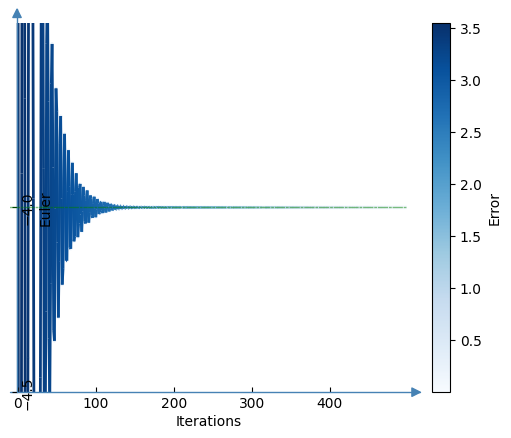

In [22]:
from matplotlib import cm, collections
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.axisartist as AA
euler_curves = np.array(euler_curves)
error = np.abs(euler_curves - (-4.0))

fig = plt.figure()
ax = fig.add_subplot(axes_class=AA.Axes)
ax.axis["right"].set_visible(False)
ax.axis["top"].set_visible(False)

ax.axis["left"].set_visible(False)
ax.axis["bottom"].set_visible(False)

gt_value = -4

ax.axis["y=0"] = ax.new_floating_axis(nth_coord=0, value= gt_value-0.5)
ax.axis["y=0"].set_axisline_style("-|>", size=1.5)
ax.axis["y=0"].line.set_color("steelblue")


ax.axis["x=0"] = ax.new_floating_axis(nth_coord=1, value=-1)
ax.axis["x=0"].set_axisline_style("-|>", size=1.5)
ax.axis["x=0"].line.set_color("steelblue")
ax.axis["x=0"].label.set_text("Euler")
ax.axis["x=0"].toggle(all=True)

ax.axis["y=01"] = ax.new_floating_axis(nth_coord=0, value=gt_value)
# ax.axis["y=01"].set_axisline_style("-.-", size=1.5)
ax.axis["y=01"].line.set_color("green")
ax.axis["y=01"].toggle(all=False)
ax.axis["y=01"].label.set_text("GT")

ax.axis["y=01"].line.set_linestyle("-.")
ax.axis["y=01"].line.set_linewidth(1)
ax.axis["y=01"].line.set_alpha(0.5)

# 使用渐变颜色方案绘制渐变线
x = np.arange(0, len(euler_curves))
y = euler_curves
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
lc = collections.LineCollection(segments, cmap='Blues_r')
lc.set_array(np.linspace(0, 1, len(x)))
lc.set_linewidth(2)

plt.gca().add_collection(lc)
plt.xlim(x.min()-10, x.max())
plt.ylim(gt_value-0.5, gt_value+0.5)
plt.scatter(x, euler_curves, s=2, c=error, cmap='Blues')
plt.colorbar(label='Error')
plt.yticks(np.arange(gt_value-0.5, gt_value+0.5, 0.5))
plt.xlabel('Iterations')

plt.savefig('euler_curve_kitty.pdf', dpi=300, bbox_inches='tight')

In [24]:
pointscloud_np = pointscloud[0].detach().cpu().numpy()

# visualize the moving frame 
pl = pv.Plotter(notebook=True)
# pl.add_points(trg_mesh.verts_packed().detach().cpu().numpy(), color='r', opacity = 0)

# pl.add_points(inside_points.detach().cpu().numpy(), color='g', opacity = 0.2)
trg_trimesh = trimesh.Trimesh(trg_mesh.verts_packed().detach().cpu().numpy(), trg_mesh.faces_packed().detach().cpu().numpy())
pl.add_mesh(trg_trimesh, color='white', opacity=1.)


# pl.add_arrows(pointscloud_np, pcl_with_frames.frames_field[:,:,0,:].detach().cpu().numpy()[0], mag=0.03, color='r', opacity=0.1)
# normal to RGB
random_idx = torch.randperm(pointscloud.shape[1])[:1000]
pl.add_arrows(pointscloud_np[random_idx], normals_gt[0].detach().cpu().numpy()[random_idx], mag=0.1, color='g', opacity=0.3)
pl.add_arrows(pointscloud_np[random_idx], pcl_with_frames.frames_field[0,:,0,:].detach().cpu().numpy()[random_idx], mag=0.1, color='r', opacity=0.3)

pl.show()

EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…

In [25]:
pointscloud_np = pointscloud[0].detach().cpu().numpy()

# visualize the moving frame 
pl = pv.Plotter(notebook=True)
# pl.add_points(trg_mesh.verts_packed().detach().cpu().numpy(), color='r', opacity = 0)

# pl.add_points(inside_points.detach().cpu().numpy(), color='g', opacity = 0.2)
trg_trimesh = trimesh.Trimesh(trg_mesh.verts_packed().detach().cpu().numpy(), trg_mesh.faces_packed().detach().cpu().numpy())
pl.add_mesh(trg_trimesh, color='white', opacity=1.)


# pl.add_arrows(pointscloud_np, pcl_with_frames.frames_field[:,:,0,:].detach().cpu().numpy()[0], mag=0.03, color='r', opacity=0.1)
# normal to RGB
random_idx = torch.randperm(pointscloud.shape[1])[:1000]
pl.add_arrows(pointscloud_np[random_idx], normals_gt[0].detach().cpu().numpy()[random_idx], mag=0.1, color='g', opacity=0.3)
pl.add_arrows(pointscloud_np[random_idx], normals_field[0,:,0,:].detach().cpu().numpy()[random_idx], mag=0.1, color='b', opacity=0.3)

pl.show()

EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…

In [ ]:
((-frames_field[0,:,0,:].detach()-normals_gt.detach())*(-normals_gt.detach())).sum(-1).mean()

tensor(0.2087, device='cuda:0')

In [ ]:
((-pcl_with_frames.frames_field[0,:,0,:].detach()-normals_gt.detach())*(-normals_gt.detach())).sum(-1).mean()

tensor(0.1721, device='cuda:0')

In [15]:
import pymeshlab
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch3d
from pytorch3d.io import load_obj, save_obj, load_objs_as_meshes
from pytorch3d.structures import Meshes, Pointclouds
from pytorch3d.ops import sample_points_from_meshes, knn_points, estimate_pointcloud_normals, knn_gather, cubify

import trimesh

from torch_scatter import scatter

from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt

import pyvista as pv
pv.start_xvfb()
pv.set_jupyter_backend('html')

import torch
import pytorch3d 
from pytorch3d.ops import knn_points,knn_gather
from pytorch3d.transforms import axis_angle_to_matrix, matrix_to_axis_angle


from tqdm import tqdm

from pytorch3d.utils import ico_sphere

# # from pytorch3d.structures import Meshes

# from .utils import one_hot_sparse

In [16]:
trimesh_new = trimesh.load_mesh("./data_example/father.obj")
trimesh_new.show()
points = pcl_with_frames.pointscloud[0].detach().cpu().numpy()
trimesh_new.vertices = points
trimesh_new.normals = normals_field[0,:,0,:].detach().cpu().numpy()

In [22]:
trimesh_new = trimesh.Trimesh(trg_mesh.verts_packed().detach().cpu().numpy(), trg_mesh.faces_packed().detach().cpu().numpy())
trimesh_new.show()
points = pcl_with_frames.pointscloud[0].detach().cpu().numpy()
trimesh_new.vertices = points
trimesh_new.normals = normals_field[0,:,0,:].detach().cpu().numpy()
trimesh_new.faces = np.zeros((1,3))

trimesh_new.export("tem.obj")



ms = pymeshlab.MeshSet()

ms.load_new_mesh("tem.obj")



# ms.compute_normal_for_point_clouds()

ms.generate_surface_reconstruction_screened_poisson()

mesh = ms.current_mesh()


# ms = pymeshlab.MeshSet()
# ms.load_new_mesh("./data_example/kitty.obj")
# # ms.meshing_surface_subdivision_butterfly()
# ms.meshing_remove_selected_faces()
# ms.compute_curvature_principal_directions_per_vertex(method = 'Scale Dependent Quadric Fitting',curvcolormethod = 'Gaussian Curvature')

# # get the value of the mean curvature
# mesh = ms.current_mesh()
# qarr = mesh.vertex_scalar_array()
# print('Gaussian Curvature range:', qarr.min(), qarr.max())
# q = np.percentile(qarr, [0.1, 0.9])

# print('Gaussian Curvature range 90 percent:', q[0], q[1])


# pl = pv.Plotter(notebook=True)
# current_trimesh = trimesh.Trimesh(vertices=mesh.vertex_matrix(), faces=mesh.face_matrix())
# pl.add_mesh(current_trimesh, scalars=qarr, cmap='jet')
# pl.show()

FileNotFoundError: [Errno 2] No such file or directory

In [21]:
ms.current_mesh?

Docstring:
current_mesh(self: pymeshlab.pmeshlab.MeshSet) -> pymeshlab.pmeshlab.Mesh

Returns the current mesh of the MeshSet. Raises a :py:exc:`PyMeshLabException` if the MeshSet has no current mesh (zero meshes).
Type:      method

In [ ]:
trimesh_new = trimesh.load_mesh("./data_example/father.obj")
trimesh_new.show()
points = trimesh.sample.sample_surface(trimesh_new, 10000)[0]

trimesh_new.vertices = points

trimesh_new.faces = trimesh_new.facess[0:1]

trimesh_new.export("./data_example/tem.obj")



ms = pymeshlab.MeshSet()

ms.load_new_mesh("./data_example/tem.obj")

ms.meshing_remove_all_faces()


ms.compute_normal_for_point_clouds()

ms.generate_surface_reconstruction_screened_poisson()

mesh = ms.current_mesh()